In [19]:
import warnings

import pandas as pd
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
     


In [20]:
categ_cols=['sla','product_type','brand','service_type','incident_type']
num_cols=['open_to_close_hour','response_to_resolved_hour']
label='severity_name'
unusedCols=['severity_id','severity_name']

target='severity'


In [21]:
# df = pd.read_csv('../data/TrainEval_Incident.csv')

def download_table(bq_table_uri: str):
    bqclient = bigquery.Client()
    # Remove bq:// prefix if present
    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix) :]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(
        table,
    )
    return rows.to_dataframe()
df=download_table("pongthorn.SMartML.TrainEval_Incident_20230316")

sr_predict=df.iloc[-1,:]
df=df.iloc[0:len(df)-1,:]
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2142 non-null   Int64  
 1   severity_name              2142 non-null   object 
 2   sla                        2142 non-null   object 
 3   product_type               2142 non-null   object 
 4   brand                      2142 non-null   object 
 5   service_type               2142 non-null   object 
 6   incident_type              2142 non-null   object 
 7   open_to_close_hour         2142 non-null   float64
 8   response_to_resolved_hour  2142 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 152.8+ KB
None


,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour
2137,4,Cosmatic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,308.166667,308.033333
2138,4,Cosmatic,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,5.516667,5.416667
2139,4,Cosmatic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,168.150000,164.666667
2140,4,Cosmatic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,163.850000,163.850000
2141,4,Cosmatic,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333,5.483333


In [22]:
df[target] = df[label].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3})

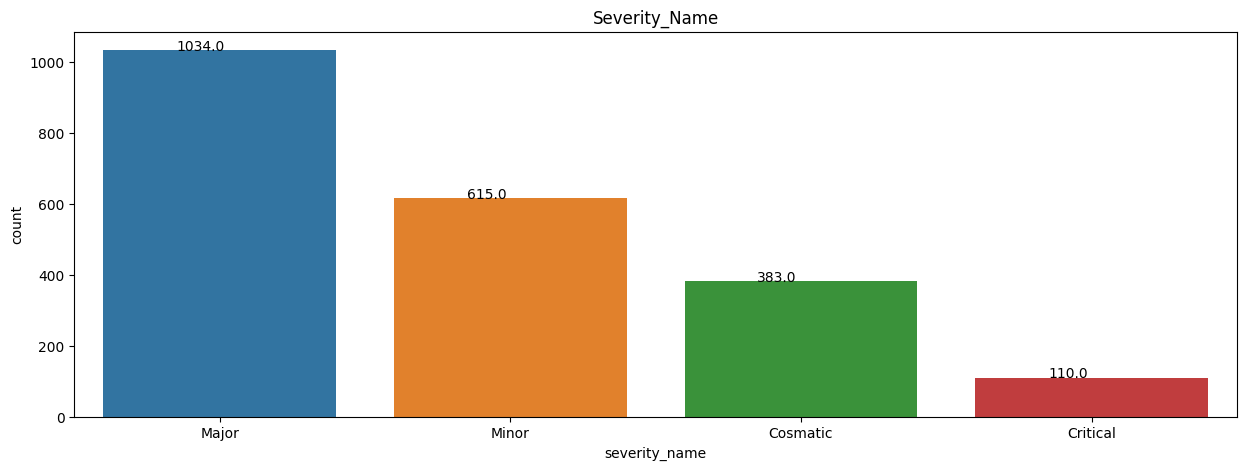

In [23]:
fig , ax = plt.subplots(figsize=(15,5))
ax =sns.countplot(x=label, data=df,)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title(label.title())
plt.show()

In [24]:


listTarget=list(df[target].unique())
nTarget=len(listTarget)
print(f"TargetLabel :{listTarget } = {nTarget}")

df=df.drop(columns=unusedCols)

print(df.info())

TargetLabel :[2, 1, 0, 3] = 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        2142 non-null   object 
 1   product_type               2142 non-null   object 
 2   brand                      2142 non-null   object 
 3   service_type               2142 non-null   object 
 4   incident_type              2142 non-null   object 
 5   open_to_close_hour         2142 non-null   float64
 6   response_to_resolved_hour  2142 non-null   float64
 7   severity                   2142 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 134.0+ KB
None


In [25]:
df.tail()

,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
2137,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,308.166667,308.033333,0
2138,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,5.516667,5.416667,0
2139,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,168.150000,164.666667,0
2140,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,163.850000,163.850000,0
2141,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333,5.483333,0


In [26]:
def encode_cols(data, col):
    # Creating a dummy variable for the variable 'CategoryID' and dropping the first one.
    categ = pd.get_dummies(data[col], prefix=col, drop_first=True)
    # Adding the results to the master dataframe
    data = pd.concat([data, categ], axis=1)
    return data


# dummy-encode the categorical fields
for i in categ_cols:
    df = encode_cols(df, i)
    df.drop(columns=[i], inplace=True)

# check the data's shape
df.shape

(2142, 59)

In [27]:
X = df[[i for i in df.columns if i != target]].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=36
)
print(X_train.shape, X_test.shape)
print(X_train.info() )
print(y_train.info())

(1713, 58) (429, 58)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1713 entries, 1493 to 645
Data columns (total 58 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   open_to_close_hour                     1713 non-null   float64
 1   response_to_resolved_hour              1713 non-null   float64
 2   sla_24x7 4Hrs Response Time            1713 non-null   uint8  
 3   sla_24x7 6Hrs Resolution Time          1713 non-null   uint8  
 4   sla_24x7 6Hrs Response Time            1713 non-null   uint8  
 5   sla_8x5 4Hrs Response Time             1713 non-null   uint8  
 6   sla_9x5xNBD 4Hrs Response Time         1713 non-null   uint8  
 7   product_type_Firewall                  1713 non-null   uint8  
 8   product_type_Hardware                  1713 non-null   uint8  
 9   product_type_Other                     1713 non-null   uint8  
 10  product_type_Security                  1713 non-n

In [28]:
scaler = StandardScaler()
X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])

In [29]:

y_train_categ = to_categorical(y_train)
y_test_categ = to_categorical(y_test)

In [30]:
optimizer = "adam"
num_hidden_layers = 2
num_neurons = [16, 16]
activ_func = ["relu", "relu"]


model = Sequential()
# construct the neural network as per the defined parameters
for i in range(num_hidden_layers):
    if i == 0:
        # add the input layer
        model.add(
            Dense(
                num_neurons[i],
                activation=activ_func[i],
                input_shape=(X_train.shape[1],),
            )
        )
    else:
        # add the hidden layers
        model.add(Dense(num_neurons[i], activation=activ_func[i]))

# add the output layer
model.add(Dense(nTarget, activation="softmax"))
# compile the model
model.compile(loss="categorical_crossentropy", optimizer=optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                944       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1,284
Trainable params: 1,284
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS = 100
BATCH_SIZE = 32
history = model.fit(X_train, y_train_categ, epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=1)

Epoch 1/100
54/54 [==============================] - 1s 3ms/step - loss: 1.3420
Epoch 2/100
54/54 [==============================] - 0s 3ms/step - loss: 1.2056
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 1.0527
Epoch 4/100
54/54 [==============================] - 0s 3ms/step - loss: 0.9244
Epoch 5/100
54/54 [==============================] - 0s 3ms/step - loss: 0.8366
Epoch 6/100
54/54 [==============================] - 0s 3ms/step - loss: 0.7889
Epoch 7/100
54/54 [==============================] - 0s 3ms/step - loss: 0.7586
Epoch 8/100
54/54 [==============================] - 0s 3ms/step - loss: 0.7402
Epoch 9/100
54/54 [==============================] - 0s 3ms/step - loss: 0.7264
Epoch 10/100
54/54 [==============================] - 0s 3ms/step - loss: 0.7156
Epoch 11/100
54/54 [==============================] - 0s 3ms/step - loss: 0.7069
Epoch 12/100
54/54 [==============================] - 0s 3ms/step - loss: 0.6976
Epoch 13/100
54/54 [=================

In [32]:
test_results = model.evaluate(X_test, y_test_categ, verbose=1)
print(f"Test results - Loss: {test_results}")

14/14 [==============================] - 0s 2ms/step - loss: 0.7566
Test results - Loss: 0.7566217184066772


In [ ]:
# GCS_PATH = BUCKET_URI + "/path-to-save/"
# model.save(GCS_PATH)